```
CIFAR10 Tutorial

Author: Nikolas Adaloglou
MIT Licence

Copyright © 2021 Nikolas Adaloglou

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation file (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish,  distribute, sublicense, and/or sell copies of the Software, and to permit  persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```


# Part 1:Train your first CNN in CIFAR10 with Pytorch 

## Basic imports
This tutorial will introduce you to python and pytorch concepts by training a convolutional neural network on cifar10. Before anything let's import all of our tools:

In [ ]:
import torch
import torchvision
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Input image transformations
Next we will define some minimal input transformatios. Generally speaking the data are usually normalized/standardized to a specific range e.g. $[0,1]$

We are dealing with RGB images here which means the input will be tensors of shape $[3, height, width]$. The images intensities are usually in the range [0,255] or [0,1] as in this case.

We could pass them in the neural network in the rane [0,1] but often standardizing with substracting the mean and dividing by the standard deviation is prefered.

$$z = \frac{(x - \mu)}{\sigma}  $$ 

Since each channel has different statistics, this operation is applied per channel  (channel-wise). That's why you will abserve 3 different means in the code snippet. The image statistics that we will use are based on an publicly available dataset called imagenet which consists of millions of images. 

If one wanted to make her/his life easy, he could use $\mu=0.5, std=0.5$ or caclulate the means and variances of the dataset himself/herself.

> An important note here that is usufull for representation learning and data augmentations is that the normalization has to be applied in the end of the transformations. 

Image augmentations can be photometric transformations i.e. sharpening an image or blurring it or geometric ones like image rotation or translation.

Images are usually loaded with an imaging processing library like opencv or pillow or even numpy arrays. Pytorch uses pillow under the hood. Ultimetly, this means that one has to convert the input images to tensor type so that the gradients can be tracked down from back-propagation.

All modern deep learning frameworks process tensors so be sure to import your data properly.



In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

normalize = transforms.Normalize(mean.tolist(), std.tolist())


transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

## Image show function

Since the image is mean/std normalized then we need to bring it back to [0,1] for visualiztion. This is achieved by canceling our previous normalization:

In [ ]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
def imshow(img):
    """
    shows an imagenet-normalized image on the screen
    """
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Load CIFAR10 dataset

Pytorch has a set of datasets that you can download and use right away in a single line of code. This process would take you hours or days dependend on your experience for a custom dataset. 

> General note: vision models are typically trained with random crops, while center crops is used during inference. This introduces a discrepancy in the object sizes seen during training and inference.

For now we don't have to deal with this issue.

The `torchvision` library of Pytorch contains code for preparing CIFAR10. 

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualizing input images

We have our data. Let's see some of them since we have a ploting functionality ready:

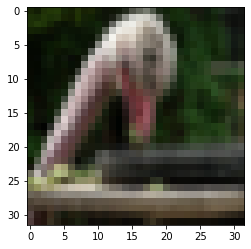

Image class: bird
Image shape is torch.Size([3, 32, 32])
Dataset size: 50000 images


In [ ]:
# load an image from the dataset
image, label = trainset[400] # index 400 here
imshow(image)
print(f"Image class: {classes[label]}")
print(f"Image shape is {image.shape}")
print(f"Dataset size: {len(trainset)} images")

## Batching images: DataLoaders
The dataset is ready but we are not quite there yet. Mini-batch gradient descent works with small batches of data, here, images.

We need another functionality to "group" images together so that they can be fed to the CNN.

The so-called batch size size in this tutorial will be 16. 

In general, we use batch sizes that are multiple of 32 in GPU's for maximum hardware utilization.

Pytorch provides the `DataLoader` class to make our lifes easier.

The process of "batching" data together is completely independent of the training, so we can have multiple threads, called workers, loading data on the cpu while our model is training on the GPU. Here we set for 2 workers.

A trick that you can do to optimize the data transfer between CPU and GPU in Pytorch is to use `pin_memory=True` in the DataLoader. This enables faster data tranfer. No need to do that on the val/test data though.

Moreover, train data need to be shuffled. You don't all dog images for instance to be on the same batch. Because this may cause information leak. This is particularly usefull in representation learning. Nonetheless, we need to make our results reproducible. That's way we will feed all the random number generators with a seed.

And tha's pretty much it for the data part!

In [ ]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    if (torch.cuda.is_available()):
        torch.cuda.manual_seed(seed)

seed_everything(99)
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, 
                                          pin_memory=True)

testloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Putting it all together

In [ ]:
def load_cifar10_data(transform, train=True, batch_size=16):
    pin = True if train else False
    dataset = torchvision.datasets.CIFAR10(root='./data',  transform=transform, download=True)
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2,
                                         pin_memory=pin)
    return loader


trainloader = load_cifar10_data(transform, True)
valloader = load_cifar10_data(transform, False)

Files already downloaded and verified
Files already downloaded and verified


# Plot a batch of data

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


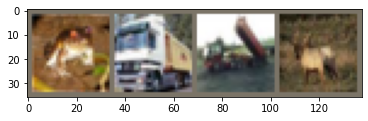


GroundTruth:   frog truck truck  deer


In [ ]:
def plot_a_batch_of_images(loader, model=None, num_images=4):
  # get some random training images
  
  images, labels = iter(loader).next()
  batch_size = images.shape[0]
  # show images
  imshow(torchvision.utils.make_grid(images[:num_images,...]))

  print('\nGroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
  if model is not None:
    model.to('cpu')
    outputs = model(images).to('cpu')
    # argmax  
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(num_images)))

plot_a_batch_of_images(trainloader)

## Create our convnet with 2 heads

Next we will create our model. We will use 3 conv layers followed by batch normalization and relu activation. Notice the order of this operations that one conv-block. Batch normalization is appied before relu so that it centers the feature before taking only the positive values with relu.

A nice exersice here would be to calclulate the spatial dimensions of the feature map based on a 32x32 image. If you cannot caclulate it you can print the shape of the tensor of the output of the backbone model. Backbone or stem is a common terminology to say that this is the part of the network that can used for transfer learning or fine-tuning.

In our case it's just training from scratch in CIFAR10. Nonetheless we will familiarize ourself with the multi-crop strategy so that we can process variable-size images, e.g. 32x32 and 16x16 images.

A different MLP , called head, will be used to infer the class image based on the features. Pay attention to the fact that both heads share the same backbone network.


You can find more about in these two papers: [HydraNet](https://openaccess.thecvf.com/content_cvpr_2018/papers/Mullapudi_HydraNets_Specialized_Dynamic_CVPR_2018_paper.pdf)
and [FixRes](https://arxiv.org/abs/1906.06423)



In [ ]:
class ConvModel(nn.Module):
    def __init__(self, in_channels=3, classes=10):
        super().__init__()
        conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 32, 5),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2, 2))
        
        conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),)

        conv3 = nn.Sequential(
                        nn.Conv2d(64, 64, 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True))
        
        self.backbone = nn.Sequential(conv1,
                                      conv2,
                                      conv3)
        
        # for different image resolutions
        self.feats32x32 = 6400
        # for 32x32 images
        self.head1 = nn.Sequential(
                        nn.Linear(6400, 128),
                        nn.ReLU(inplace=True),
                        nn.Linear(128, classes))
        
        # for 16x16 images
        self.head2 = nn.Sequential(
                        nn.Linear(256, 128),
                        nn.ReLU(inplace=True),
                        nn.Linear(128, classes))

    def forward(self, x):
        batch_size = x.shape[0]
        representation = self.backbone(x)
        # flattens all dimensions except the batch dim
        # -1 is for computing automatically
        z = representation.view(batch_size,-1) 
        return self.head1(z) if z.shape[-1] == self.feats32x32 else self.head2(z)



## Test our model on dummy data: mocking

A good strategy is to perform a forward pass and see that our model outputs the expected tensor shape.

In [ ]:
net = ConvModel()
a = torch.rand(1,3,32,32)
b = torch.rand(1,3,32,32)
y1 = net(a)
y2 = net(b)

assert y1.shape == y2.shape
assert y1.shape[-1] == 10
print(y1.shape)
print('Test OK!')

torch.Size([1, 10])
Test OK!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Optimizers and cross entropy loss function

Our fancy conv net has roughly 1M parameters. This will be optimized with our SGD optimizer that is responsible for clearning out previous gradient values and storing the gradients of the current step, as well as updating the actual model's parameters based on the update rule.

Different optimizers vary on the different update rules. Here we will just use SGD.

Additionally we will use the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss. It accepts the pred and target when calling it

`loss_scalr_value = criterion(pred,target)`

Target is usually a integer tensor which indicates the class number. The conversion to one-hot-encoding is happening internally.


In [ ]:
import torch.optim as optim

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)/1000000

print(f"Parameters: {pytorch_total_params} millions")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Parameters: 0.91298 millions


# The training loop

You need to familiarize yourself with runnning training loops. Here is a minimall training loop with some comments to help you understand what's happening.

The training will be held on the GPU `device` so each batch needs to be moved to the GPU before being fed into the model. The model is moved to the GPU before training.

The best practice here is to minimize CPU <--> GPU communication.


In [ ]:
import torch.optim as optim

def train(model, trainloader, epochs, device):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  model.train()
  model.to(device)
  epoch_loss = []
  # loop over the dataset multiple times
  for epoch in range(epochs):  
      running_loss = 0.0
      for i, data in enumerate(trainloader):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device) , data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # track statistics
          running_loss += loss.item()
      print(f"Epoch [{epoch + 1} / {epochs}] Loss: {running_loss/len(trainloader)}")
      epoch_loss.append(running_loss)
      running_loss = 0.0
      

  print('Finished Training')
  return model,epoch_loss

# Test and visual evaluation

This function will evaluate our model's performance for the test set and/or val set. We use argmax `_, predicted_argmax = torch.max(outputs.data, 1)` to get the class index.

In [ ]:
def test(model, device, testloader):
  correct = 0
  total = 0
  model.eval()
  model.to(device)
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device) , data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # argmax: the class with the highest probability is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
    

# Main function

Let put everything togeher and let it run! 

Observe how the initial acccuracy that is actually a random guess skyrockets even from the first epoch!

In [ ]:
def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainloader = load_cifar10_data(transform, True, batch_size=32)
    valloader = load_cifar10_data(transform, False, batch_size=64)

    model = ConvModel()
    # let's test model's initial accuracy for comparison
    test(model, device, valloader)

    model, epoch_losses = train(model, trainloader, epochs=2, device=device)

    test(model, device, valloader)
    
    plot_a_batch_of_images(valloader,model)
    
main()

Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: ignored

# Warmup exercise: plot the training loss per epoch

Hint: You can use `matplotlib`. Both points and line should be depicted. 

# Part 2: Pass multiple image resolutions to your model at once: multi-crop train strategy

Make your code support multiple image resolutions. Accumulate all the class prediction from all image tensor so that they can be used for training.


Comments can be completely ignored. Think your own solution first.

Comment indentation level is left based on the solution. You may find that helpful.

`Hint`: image of the same resolution will be continouous in the list of tensors i.e 3 images 32x32 followed by 2 images of 16x16. 

In [ ]:
class ConvCropWrapper(nn.Module):
    """
    Perform forward pass separately on each resolution input.
    The inputs corresponding to a single resolution are clubbed and single
    forward is run on the same resolution inputs.
    A different head will be used for each image resolution. 
    """
    def __init__(self, in_channels=3, classes=10):
        super(ConvCropWrapper, self).__init__()
        
        # self.backbone = ...
        
        # for 32x32 images
        # self.head1 = ...
        
        # for 16x16 images
        #self.head2 = n...

    def forward(self, x):
        # if the input is not a list of images place the tensor(s) on a list
        # this ensures backward compatibility with the prev. version


        
        # find crop index/indices that you should split the list


        # perform different forward pass for each image resolution


            # flattens all dimensions except the batch dim

            # pass representation to the corresponding head 


            # accumulate outputs

        # return the accumulated result
        return 

# test functionality to test your wrapper.
# if you have succeded implementing it then you will see the message:
# Test Passed!!!
def test_multi_crop_wrapper():
  list_images = []
  batch_size = 2
  total_views = 6
  classes = 10
  for i in range(2):
    list_images.append(torch.rand(batch_size, 3,32,32))

  for i in range(4):
    list_images.append(torch.rand(batch_size, 3,16,16))

  model = ConvCropWrapper(classes=classes)
  y = model(list_images)
  print('Out tensor shape:', y.shape)
  assert y.shape == (total_views*batch_size, classes)
  print('Test Passed!!!')


test_multi_crop_wrapper()

AttributeError: ignored

# Solution to Part 2

In [ ]:
class ConvCropWrapper(nn.Module):
    """
    Perform forward pass separately on each resolution input.
    The inputs corresponding to a single resolution are clubbed and single
    forward is run on the same resolution inputs.
    A different head will be used for each image resolution. 
    """
    def __init__(self, in_channels=3, classes=10):
        super(ConvCropWrapper, self).__init__()
        conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 32, 5),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2, 2))
        
        conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True))

        conv3 = nn.Sequential(
                        nn.Conv2d(64, 64, 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True))
        
        self.backbone = nn.Sequential(conv1,
                                      conv2,
                                      conv3)
        # for different image resolutions
        self.feats32x32 = 6400
        # for 32x32 images
        self.head1 = nn.Sequential(
                        nn.Linear(6400, 128),
                        nn.ReLU(inplace=True),
                        nn.Linear(128, classes))
        
        # for 16x16 images
        self.head2 = nn.Sequential(
                        nn.Linear(256, 128),
                        nn.ReLU(inplace=True),
                        nn.Linear(128, classes))

    def forward(self, x):
        # if the input is not a list of images convert to a list
        # this ensures backward compatibility with the prev. version
        if not isinstance(x, list):
            x = [x]
        
        # find crop index/indices that you should split the list
        idx_crops = torch.cumsum(torch.unique_consecutive(
            torch.tensor([inp.shape[-1] for inp in x]),
            return_counts=True,
        )[1], 0)

        # perform different forward pass for each image resolution
        start_idx, output = 0, torch.empty(0).to(x[0].device)
        for end_idx in idx_crops:
            representation = self.backbone(torch.cat(x[start_idx: end_idx],dim=0))

            # flattens all dimensions except the batch dim
            z = torch.flatten(representation,1)

            # pass representation to the corresponding head 
            _out = self.head1(z) if z.shape[-1] == self.feats32x32 else self.head2(z)

            # accumulate outputs
            output = torch.cat((output, _out))
            start_idx = end_idx
        # return the accumulated result
        return output

def test_multi_crop_wrapper():
  list_images = []
  batch_size = 2
  total_views = 6
  classes = 10
  for i in range(2):
    list_images.append(torch.rand(batch_size, 3,32,32))

  for i in range(4):
    list_images.append(torch.rand(batch_size, 3,16,16))

  model = ConvCropWrapper(classes=classes)
  y = model(list_images)
  print('Out tensor shape:', y.shape)
  assert y.shape == (total_views*batch_size, classes)
  print('Test Passed!!!')


test_multi_crop_wrapper()

Out tensor shape: torch.Size([12, 10])
Test Passed!!!


# Part 3: use our dataloader to train the Multi-res Conv net class in CIFAR10

Below you will find the Dataloader that returns a series of CIFAR10 images with multiple resolutions. Use it to train your CNN model. This time the data will be augmented using random color jiterring and random horizontal flipping and random conversion to greyscale.

This transformations are super common in visual self-supervised learning. Effectivly, augmentations increase the variability of the data so that it make sense to have multiple "views" of the same image. A view is defined as a stochastic image transformation.

This idea is of particular interest for representation learning.

- Train the model for the same epochs and compare test accuracies.

- Plot the losses together comparing the 2 solutions

- Plot the model accuracies in a bar plot with `matplotlib`

Files already downloaded and verified
4
Files already downloaded and verified
torch.Size([16, 3, 32, 32])
torch.Size([16, 3, 16, 16])


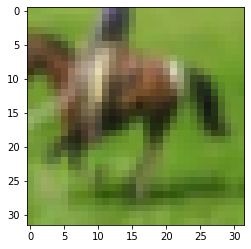

horse


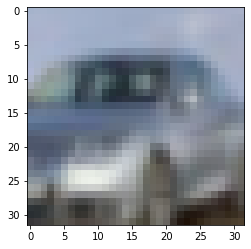

car


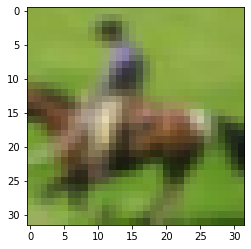

horse
Test passed
torch.Size([16])


In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MultiCropCIFAR10(Dataset):
    """
    returns an extra binary label: 0 for non-rotated and 1 for rotated images
    """
    def __init__(self, global_crops, local_crops, train=True):
        super().__init__()
        self.global_crops = global_crops
        self.local_crops = local_crops
        self.dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=None)
        self.create_transforms()

    def create_transforms(self):
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        self.crop32x32 = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=[0.5,1]),
            normalize ])
        
        self.crop16x16 = transforms.Compose([
            transforms.RandomResizedCrop(16, scale=[0.1,0.5]),
            normalize])
    
    def get_crops(self, image):
        crops = []

        for i in range(self.global_crops):
            crops.append(self.crop32x32(image))

        for i in range(self.local_crops):
            crops.append(self.crop16x16(image))
  
        return crops

    def __getitem__(self, index):
        img, label = self.dataset[index]
        # transform
        crops = self.get_crops(img)
        labels = [label] * len(crops)
        return crops, labels

    def __len__(self):
        return len(self.dataset)



def load_cifar10_multi_crop(train=True, global_crops=2, local_crops=2, batch_size = 16):
  mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
  std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

  shuffle = True if train else False

  normalize = transforms.Normalize(mean.tolist(), std.tolist())

  flip_and_color_jitter = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
            p=0.8
        ),
  transforms.RandomGrayscale(p=0.2),
    ])

  transform = transforms.Compose(
    [transforms.ToTensor(),
    flip_and_color_jitter,
      normalize])


  dataset = MultiCropCIFAR10(global_crops, local_crops, train=train)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=shuffle, num_workers=2)
  return loader


def test_MultiCropCIFAR10():
  dataset = MultiCropCIFAR10(2,2)
  list_img, labels = dataset[1]
  print(len(list_img))

  data = next(iter(load_cifar10_multi_crop()))
  img_list , labels = data 

  print(img_list[0].shape)
  print(img_list[-1].shape)
  assert  img_list[0].shape == (16,3,32,32)
  assert  img_list[-1].shape == (16,3,16,16)
  # first batch first img
  imshow(img_list[0][0])
  print( classes[labels[0][0]])
  # first batch second img
  imshow(img_list[0][1])
  print( classes[labels[0][1]])
  # second batch first img
  imshow(img_list[1][0])
  print( classes[labels[1][0]])
  print("Test passed")

  print(labels[0].shape)

test_MultiCropCIFAR10()


## Rewrite/adjust the train logic to support multi-res input and perform GPU training

Now you need to revisit the train function and make some changes to support our multi-crop dataloader and are ConvModel that processes the images. 

Time to make your hands dirty! Training must be held on the GPU.

The `main` function is given to test if your training code is working.


In [ ]:
import torch.optim as optim

def train(model, training_data, epochs, device):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  model.train()
  model.to(device)
  epoch_loss = []
  for epoch in range(epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(training_data):
          
          
          # don't forget to move the data on the gpu
          #images = ....
          #labels = ....

          # this is the same as before
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      print(f"Epoch [{epoch + 1} / {epochs}] Loss: {running_loss/len(trainloader)}")
      epoch_loss.append(running_loss)
      running_loss = 0.0
      

  print('Finished Training')
  return model,epoch_loss

def main():
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

    normalize = transforms.Normalize(mean.tolist(), std.tolist())

    transform_val = transforms.Compose(
        [transforms.ToTensor(),
        normalize])
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainloader = load_cifar10_multi_crop(True, batch_size=16)
    valloader = load_cifar10_data(transform_val, False, batch_size=16)

    model = ConvCropWrapper()

    model, epoch_losses = train(model, trainloader, epochs=1, device=device)    
    
main()

# Solution to part 3

In [ ]:
import torch.optim as optim

def train(model, training_data, epochs, device):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  model.train()
  model.to(device)
  epoch_loss = []
  for epoch in range(epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(training_data):
          # get the inputs; data is a list of [images, labels]
          # where images is again a list of tensors 
          images, labels = data[0] , data[1]

          images = [im.cuda(non_blocking=True) for im in images]
          labels = torch.cat(labels).cuda(non_blocking=True)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
      print(f"Epoch [{epoch + 1} / {epochs}] Loss: {running_loss/len(trainloader)}")
      epoch_loss.append(running_loss)
      running_loss = 0.0

  print('Finished Training')
  return model,epoch_loss

def main():
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

    normalize = transforms.Normalize(mean.tolist(), std.tolist())

    transform_val = transforms.Compose(
        [transforms.ToTensor(),
        normalize])
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainloader = load_cifar10_multi_crop(True, batch_size=16)
    valloader = load_cifar10_data(transform_val, False, batch_size=16)

    model = ConvCropWrapper()

    model, epoch_losses = train(model, trainloader, epochs=10, device=device)

    test(model, device, valloader)
    
    
main()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1 / 10] Loss: 1.7671544968414306
Epoch [2 / 10] Loss: 1.5442473437118531
Epoch [3 / 10] Loss: 1.4468492957496644
Epoch [4 / 10] Loss: 1.3803946655082702
Epoch [5 / 10] Loss: 1.325849211025238
Epoch [6 / 10] Loss: 1.2890405078315734
Epoch [7 / 10] Loss: 1.2533526002502442
Epoch [8 / 10] Loss: 1.2267106186294556
Epoch [9 / 10] Loss: 1.2038408518218995
Epoch [10 / 10] Loss: 1.1824073246002198
Finished Training
Accuracy of the network on the 10000 test images: 81 %


# Conclusion


Bonus read: https://theaisummer.com/self-supervised-representation-learning-computer-vision/